<a href="https://colab.research.google.com/github/NelisLima/data_science/blob/main/6_machine_learning_analise_sentimento_mercado_blockchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Projeto de Data Science - Machine Learning</font>

### Análise de Sentimento de Mercado Blockchain Analytics Para Criptoativos com Machine Learning</font>

### Instalando e Carregando Pacotes

In [ ]:
# Imports
import rich
import torch
import langid
import sklearn
import datasets
import transformers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from rich.progress import track
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('max_colwidth', None)

### Carregando e Compreendendo os Dados

In [ ]:
# Carrega o dataset
df = pd.read_csv('dataset.csv')

In [ ]:
# Shape
df.shape

(138, 4)

In [ ]:
# Amostra
df.head()

,ID,Data,texto,sentimento
0,0,2024-07-01,Bitcoin atinge novo recorde histórico! #Bitcoin #Cripto,Positivo
1,1,2024-07-01,Ethereum está revolucionando o mercado de contratos inteligentes.,Positivo
2,2,2024-07-01,Cardano e Polkadot são as criptomoedas mais promissoras do ano.,Positivo
3,3,2024-07-01,"Investir em criptomoedas pode ser arriscado, mas também muito lucrativo.",Positivo
4,4,2024-07-01,A adoção de Bitcoin como moeda legal em países emergentes está crescendo.,Positivo


In [ ]:
# Contagem de registros por classe
sentiment_count = df['sentimento'].value_counts()

In [ ]:
print(sentiment_count)

sentimento
Positivo    50
Negativo    48
Neutro      40
Name: count, dtype: int64


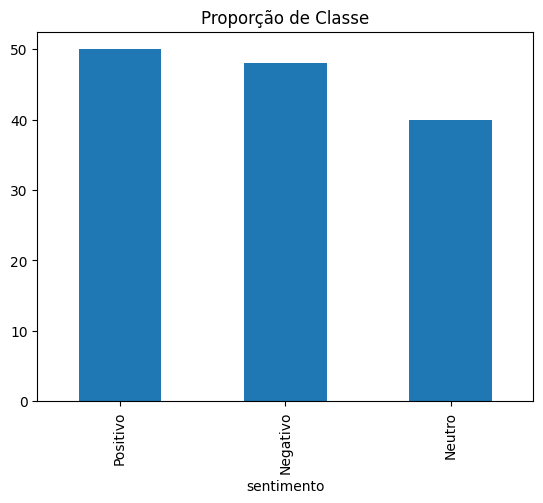

In [ ]:
# Visualizando a proporção de classes
df['sentimento'].value_counts().plot(kind = 'bar', title = 'Proporção de Classe');

### Detecção Automática de Idioma dos Dados

In [ ]:
# Cria uma nova coluna no dataframe
df['lang'] = None

In [ ]:
# Amostra
df.head()

,ID,Data,texto,sentimento,lang
0,0,2024-07-01,Bitcoin atinge novo recorde histórico! #Bitcoin #Cripto,Positivo,None
1,1,2024-07-01,Ethereum está revolucionando o mercado de contratos inteligentes.,Positivo,None
2,2,2024-07-01,Cardano e Polkadot são as criptomoedas mais promissoras do ano.,Positivo,None
3,3,2024-07-01,"Investir em criptomoedas pode ser arriscado, mas também muito lucrativo.",Positivo,None
4,4,2024-07-01,A adoção de Bitcoin como moeda legal em países emergentes está crescendo.,Positivo,None


In [ ]:
# Loop para percorrer cada linha do DataFrame e detectar o idioma do texto
for index, row in track(df.iterrows(), total = len(df)):

    # Extrai o texto da coluna 'texto' da linha atual
    text = row['texto']

    # Verifica se o texto é uma string válida
    if isinstance(text, str):

        # Classifica o idioma do texto e obtém a confiança da classificação
        language, confidence = langid.classify(text)

        # Atribui o idioma detectado à coluna 'lang' no DataFrame
        df.at[index, 'lang'] = language
    else:

        # Se o texto não for uma string válida, marca o idioma como 'desconhecido'
        df.at[index, 'lang'] = 'desconhecido'

Output()

In [ ]:
# Amostra
df.sample(10)

,ID,Data,texto,sentimento,lang
58,58,2024-07-01,Criptomoedas são usadas para lavagem de dinheiro?,Negativo,pt
29,29,2024-07-01,"O mercado cripto está cada vez mais regulamentado, o que traz segurança.",Positivo,pt
50,50,2024-07-01,A volatilidade das criptomoedas está assustando os investidores.,Negativo,pt
85,85,2024-07-01,O mercado cripto é conhecido por suas grandes oscilações de preço.,Negativo,pt
44,44,2024-07-01,Muitos especialistas acreditam no potencial de valorização do Bitcoin.,Positivo,pt
42,42,2024-07-01,A escalabilidade das criptomoedas está melhorando com novas soluções.,Positivo,pt
123,123,2024-07-01,A aceitação de criptomoedas como pagamento está aumentando lentamente.,Neutro,pt
98,98,2024-07-01,Regulamentações para criptomoedas estão sendo discutidas globalmente.,Neutro,pt
13,13,2024-07-01,Blockchain pode revolucionar diversos setores além das criptomoedas.,Positivo,pt
101,101,2024-07-01,Como proteger suas criptomoedas de hackers e fraudes?,Neutro,pt


### Limpeza dos Dados

In [ ]:
# Vamos usar somente registros com texto detectado como português
df = df[df['lang'] == 'pt']

In [ ]:
# Shape
df.shape

(129, 5)

https://docs.python.org/3.11/library/re.html

In [ ]:
# Aplica expressão regular para limpar o texto
df['texto'] = df['texto'].str.replace(r'http\S+', '', regex=True).str.replace(r'#\w+', '', regex=True).str.replace(r'@\w+', '', regex=True).str.replace(r'\d+', '', regex=True)

Explicação detalhada da linha de código acima.

**df_dsa['texto'].str.replace(r'http\S+', '', regex=True):**

Função: Substitui todas as URLs por uma string vazia, removendo-as do texto.

Expressão Regular r'http\S+':

http: Procura por qualquer sequência de caracteres que começa com "http".

\S+: Combina qualquer sequência de caracteres que não sejam espaços (representando o resto da URL).

Resultado: URLs completas (por exemplo, "http://example.com") são removidos do texto.

**str.replace(r'#\w+', '', regex=True):**

Função: Remove hashtags do texto.

Expressão Regular r'#\w+':

#: Procura pelo caractere de hashtag.

\w+: Combina uma sequência de caracteres alfanuméricos (letras, números ou underscore), que representa o conteúdo da hashtag.

Resultado: Hashtags como "#Bitcoin" são removidas do texto.

**str.replace(r'@\w+', '', regex=True):**

Função: Remove menções de usuário do texto (por exemplo, "@username").

Expressão Regular r'@\w+':

@: Procura pelo caractere de arroba.

\w+: Combina uma sequência de caracteres alfanuméricos (letras, números ou underscore), representando o nome do usuário.

Resultado: Menções como "@user123" são removidas do texto.

**str.replace(r'\d+', '', regex=True):**

Função: Remove todos os números do texto.

Expressão Regular r'\d+':

\d+: Combina uma ou mais ocorrências de dígitos (números).

Resultado: Sequências de números, como "2023" ou "123", são removidas do texto.

In [ ]:
# Mapeamento de sentimento para valor numérico
sentiment_mapping = {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}

In [ ]:
# Aplica o mapeamento e cria uma nova coluna
df['label'] = df['sentimento'].map(sentiment_mapping)

In [ ]:
# Amostra
df.sample(10)

,ID,Data,texto,sentimento,lang,label
78,78,2024-07-01,A instabilidade do mercado cripto é um grande desafio.,Negativo,pt,0
87,87,2024-07-01,O uso de criptomoedas em atividades criminosas está aumentando.,Negativo,pt,0
105,105,2024-07-01,"O futuro das criptomoedas é incerto, mas promissor.",Neutro,pt,1
14,14,2024-07-01,O interesse em criptomoedas está crescendo entre jovens investidores.,Positivo,pt,2
27,27,2024-07-01,Empresas de tecnologia estão investindo pesado em blockchain.,Positivo,pt,2
99,99,2024-07-01,Governos consideram a criação de suas próprias moedas digitais.,Neutro,pt,1
121,121,2024-07-01,"O uso de criptomoedas está crescendo, mas ainda é limitado.",Neutro,pt,1
38,38,2024-07-01,As criptomoedas podem democratizar o acesso ao sistema financeiro.,Positivo,pt,2
17,17,2024-07-01,Novas tecnologias blockchain estão sendo desenvolvidas para melhorar a eficiência.,Positivo,pt,2
41,41,2024-07-01,A blockchain pode resolver muitos problemas de confiança no mercado.,Positivo,pt,2


### Ajuste Fino do Modelo de Análise de Sentimento

https://huggingface.co/google-bert/bert-base-uncased

In [ ]:
# Define o modelo
modelo = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ao carregar o modelo pré-treinado bert-base-uncased, o Hugging Face Transformers carrega os pesos para as camadas do modelo BERT, que foram treinados em uma tarefa de pré-treinamento (por exemplo, predição de palavras mascaradas).

No entanto, as camadas específicas de classificação (como classifier.bias e classifier.weight) não são carregadas a partir do checkpoint do modelo pré-treinado. Isso ocorre porque essas camadas não existiam no modelo original de pré-treinamento.

Essas camadas são "novas", criadas para a tarefa específica de classificação que você está definindo (BertForSequenceClassification com num_labels = 3). Portanto, os pesos dessas camadas são inicializados aleatoriamente.

A mensagem sugere que você deve treinar o modelo em uma tarefa específica ("down-stream task") com seus próprios dados. Isso é exatamente o que iremos fazer.

In [ ]:
# Define o tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Cria uma função para aplicar a tokenização
def dsa_tokeniza_dados(examples):
    return tokenizer(examples['texto'], padding = 'max_length', truncation = True)

In [ ]:
# Coloca os dados no formato Dataset para acelerar a performance do treinamento
dataset = Dataset.from_pandas(df[['texto', 'label']])

In [ ]:
type(dataset)

datasets.arrow_dataset.Dataset

In [ ]:
# Aplica a tokenização aos dados
tokenized_datasets = dataset.map(dsa_tokeniza_dados, batched = True)

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

Dataset({
    features: ['texto', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 129
})

In [ ]:
tokenized_datasets[0]

{'texto': 'Bitcoin atinge novo recorde histórico!  ',
 'label': 2,
 '__index_level_0__': 0,
 'input_ids': [101,
  2978,
  3597,
  2378,
  2012,
  23496,
  24576,
  2501,
  2063,
  3181,
  2080,
  999,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [ ]:
# Proporção de divisão dos dados em treino e teste
train_test_split_ratio = 0.8

In [ ]:
# Cria o split de divisão dos dados em treino e teste
split = tokenized_datasets.train_test_split(test_size = 1 - train_test_split_ratio)

In [ ]:
# Define os dados de treino e teste
dataset_treino = split['train']
dataset_teste = split['test']

### Função de Cálculo das Métricas

In [ ]:
# Define a função para calcular as métricas
def calcula_metricas(p):

    # Obtém as previsões a partir das probabilidades, escolhendo a classe com maior probabilidade
    preds = np.argmax(p.predictions, axis = 1)

    # Calcula as métricas de precisão, recall e F1-score usando a média ponderada
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average = 'weighted')

    # Calcula a acurácia das previsões
    acc = accuracy_score(p.label_ids, preds)

    # Retorna um dicionário com as métricas calculadas: acurácia, F1-score, precisão e recall
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

### Definindo os Argumentos de Treino

Veja a descrição dos parâmetros no videobook do Capítulo 20 do curso.

In [ ]:
# Define training arguments
training_args = TrainingArguments(output_dir = './resultados',
                                  eval_strategy = 'epoch',
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = 8,
                                  per_device_eval_batch_size = 8,
                                  num_train_epochs = 10,
                                  weight_decay = 0.01,
                                  gradient_accumulation_steps = 2,
                                  logging_steps = 2)

In [ ]:
# Cria o data collator
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

A linha acima cria uma instância de DataCollatorWithPadding, que é uma classe do Hugging Face Transformers. Ela é usada para preparar os lotes de dados (batches) de entrada para o modelo de forma que todos os itens em um lote tenham o mesmo comprimento.

**Preenchimento Dinâmico (Padding):**

Textos de entrada podem ter comprimentos variados. Para processá-los em paralelo no modelo, é necessário que todos os textos em um lote tenham o mesmo comprimento.

DataCollatorWithPadding aplica preenchimento (padding) automaticamente, adicionando tokens de preenchimento ([PAD]) ao final dos textos mais curtos até que todos os textos no lote tenham o mesmo comprimento que o mais longo.

**Integração com o Tokenizer:**

O tokenizer é passado como argumento para o DataCollatorWithPadding porque ele sabe qual token deve ser usado para o preenchimento e como aplicar esse preenchimento de forma consistente com o vocabulário e as regras do modelo.

**Facilita o Processamento em Batches:**

Quando você treina ou avalia o modelo em batches, DataCollatorWithPadding assegura que todos os textos em um batch tenham o mesmo comprimento, facilitando o processamento eficiente pelo modelo. Isso é especialmente útil quando se usa o DataLoader para carregar os dados em batches para o treinamento.

### Treinamento do Modelo Para Ajuste Fino

In [ ]:
# Cria o objeto de treinamento do modelo
treina_modelo = Trainer(model = modelo,
                            args = training_args,
                            train_dataset = dataset_treino,
                            eval_dataset = dataset_teste,
                            tokenizer = tokenizer,
                            data_collator = data_collator,
                            compute_metrics = calcula_metricas)

In [ ]:
%%time
treina_modelo.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.078000,1.206630,0.269231,0.167205,0.138763,0.269231
2,1.020400,1.307794,0.153846,0.042440,0.024615,0.153846
3,1.066600,1.267691,0.230769,0.157472,0.231884,0.230769
4,1.060800,1.295039,0.192308,0.105495,0.179487,0.192308
5,0.792800,1.280297,0.230769,0.149901,0.181818,0.230769
6,0.655000,1.230108,0.269231,0.249453,0.478138,0.269231
7,0.580100,1.285604,0.269231,0.223590,0.721612,0.269231
8,0.805900,1.311996,0.230769,0.221102,0.484615,0.230769
9,0.574700,1.245913,0.307692,0.324009,0.583333,0.307692
10,0.636600,1.266761,0.307692,0.324009,0.583333,0.307692


CPU times: user 1h 41min 39s, sys: 4min 3s, total: 1h 45min 43s
Wall time: 1h 47min 52s


TrainOutput(global_step=70, training_loss=0.833766313961574, metrics={'train_runtime': 6471.2928, 'train_samples_per_second': 0.159, 'train_steps_per_second': 0.011, 'total_flos': 271006820259840.0, 'train_loss': 0.833766313961574, 'epoch': 10.0})

### Avaliando e Salvando o Modelo Para Deploy

In [ ]:
# Avalia o modelo treinado
eval_result = treina_modelo.evaluate()
print(eval_result)

{'eval_loss': 1.266761064529419, 'eval_accuracy': 0.3076923076923077, 'eval_f1': 0.324009324009324, 'eval_precision': 0.5833333333333333, 'eval_recall': 0.3076923076923077, 'eval_runtime': 40.2831, 'eval_samples_per_second': 0.645, 'eval_steps_per_second': 0.099, 'epoch': 10.0}


In [ ]:
# Salva modelo e tokenizador
modelo.save_pretrained('./modelo_final')
tokenizer.save_pretrained('./modelo_final')

('./modelo_final/tokenizer_config.json',
 './modelo_final/special_tokens_map.json',
 './modelo_final/vocab.txt',
 './modelo_final/added_tokens.json')